In [77]:
! pip install torch torchvision torch-geometric Pillow numpy einops scikit-learn kagglehub scikit-image timm matplotlib

In [78]:

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import timm
from sklearn.metrics.pairwise import cosine_similarity

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.



In [79]:
import os

# ---------------------
# 1. Set Model Cache Directory (Avoid Disk Full)
# ---------------------
# Create a more reliable path for the TORCH_HOME
# Using a directory in the user's home folder is more reliable than using a drive root
torch_home = os.path.join(os.path.expanduser("~"), ".torch")
os.environ['TORCH_HOME'] = torch_home
os.makedirs(os.environ['TORCH_HOME'], exist_ok=True)
print(f"PyTorch models will be cached in: {torch_home}")


PyTorch models will be cached in: C:\Users\DELL-RL\.torch


In [80]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunnykakar/shoes-dataset-real-and-ai-generated-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL-RL\.cache\kagglehub\datasets\sunnykakar\shoes-dataset-real-and-ai-generated-images\versions\2
Path to dataset files: C:\Users\DELL-RL\.cache\kagglehub\datasets\sunnykakar\shoes-dataset-real-and-ai-generated-images\versions\2


In [81]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# ----------------------------------
# 1. ViT-Compatible Transform
# ----------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [82]:
import cv2
# ---------------------
# Preprocessing Functions
# ---------------------
def apply_otsu(gray_image):
    _, otsu_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image

def apply_kmeans(rgb_image, k=3):
    pixels = rgb_image.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = centers[labels.flatten()].reshape(rgb_image.shape).astype(np.uint8)
    return segmented_image

def plot_comparisons(original_rgb, clahe_rgb, otsu_rgb, kmeans_rgb):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    images = [original_rgb, clahe_rgb, otsu_rgb, kmeans_rgb]
    titles = ['Original', 'CLAHE', 'Otsu Thresholding', 'K-Means Clustering']
    for ax, img, title in zip(axs.flatten(), images, titles):
        ax.imshow(img if img.ndim == 3 else img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_metrics_chart(df, image_path):
    image_name = os.path.basename(image_path)
    if image_name in df['image'].values:
        image_metrics = df[df['image'] == image_name]
        plt.bar(image_metrics['metric'], image_metrics['value'], color='skyblue')
        plt.title(f'Metrics for {image_name}')
        plt.xlabel('Metric')
        plt.ylabel('Value')
        plt.show()
    else:
        print(f"No metrics found for {image_name}")

# ---------------------
# Dataset Class
# ---------------------
class ProductDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = [], []
        self.categories = {"real": 0, "ai-midjourney": 1}

        for category, label in self.categories.items():
            category_path = os.path.join(root_dir, category)
            if not os.path.exists(category_path):
                print(f"Warning: {category_path} does not exist.")
                continue
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    Image.open(img_path)  # Validate image
                    self.images.append(img_path)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Could not open image {img_path}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# ---------------------
# Transform and Device
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [83]:

# ---------------------
# ViT Feature Extractor
# ---------------------
class ViTFeatureExtractor(nn.Module):
    def __init__(self, freeze_vit=True):
        super(ViTFeatureExtractor, self).__init__()
        # Load a pretrained ViT model, but remove the final classification head.
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove the classification head to use the output features
        if freeze_vit:
            for param in self.vit.parameters():
                param.requires_grad = False  # Freeze the weights if needed

    def forward(self, x):
        # Pass the input through ViT to extract features
        return self.vit(x)


# ---------------------
# GNN Feature Extractor
# ---------------------
class GNNFeatureExtractor(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(GNNFeatureExtractor, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x


# ---------------------
# Combined Model
# ---------------------
class ViT_GNN_Classifier(nn.Module):
    def __init__(self, freeze_vit=True):
        super(ViT_GNN_Classifier, self).__init__()
        self.vit = ViTFeatureExtractor(freeze_vit=freeze_vit)
        
        # No need for vit_to_gnn transformation in this case
        
        self.gnn = GNNFeatureExtractor(in_features=384, hidden_dim=128, out_features=128)
        self.fc = nn.Linear(128, 2)

    def forward(self, x, graph_data):
        vit_features = self.vit(x)  # ViT output with 384 features
        gnn_features = self.gnn(graph_data)
        combined = vit_features[:, :128] + gnn_features  # Element-wise fusion
        return self.fc(combined)



In [84]:

# ---------------------
# Real Graph Generation
# ---------------------
def generate_real_graph(vit_features):
    features = vit_features.detach().cpu().numpy()
    similarity = cosine_similarity(features)
    threshold = 0.8  # Only connect highly similar images

    edge_index = []
    for i in range(similarity.shape[0]):
        for j in range(similarity.shape[1]):
            if i != j and similarity[i, j] > threshold:
                edge_index.append([i, j])

    if not edge_index:
        edge_index = [[i, (i + 1) % len(features)] for i in range(len(features))]  # fallback

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
    return Data(x=vit_features.to(device), edge_index=edge_index)

# ---------------------
# Preprocessing Functions
# ---------------------
def apply_otsu(gray_image):
    _, otsu_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image

def apply_kmeans(rgb_image, k=3):
    pixels = rgb_image.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = centers[labels.flatten()].reshape(rgb_image.shape).astype(np.uint8)
    return segmented_image

def preprocess_image(image_path):
    """
    Apply preprocessing steps (CLAHE, Otsu, and KMeans) to an image.
    """
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Error reading image: {image_path}")
    
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    otsu = apply_otsu(gray)
    kmeans = apply_kmeans(original_rgb)

    return clahe, otsu, kmeans

# ---------------------
# Dataset Class with Preprocessing
# ---------------------
class ProductDataset(Dataset):
    def __init__(self, root_dir, transform=None, preprocess=True):
        self.root_dir = root_dir
        self.transform = transform
        self.preprocess = preprocess
        self.images, self.labels = [], []
        self.categories = {"real": 0, "ai-midjourney": 1}

        for category, label in self.categories.items():
            category_path = os.path.join(root_dir, category)
            if not os.path.exists(category_path):
                print(f"Warning: {category_path} does not exist.")
                continue
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    Image.open(img_path)  # Validate image
                    self.images.append(img_path)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Could not open image {img_path}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        if self.preprocess:
            clahe, otsu, kmeans = preprocess_image(image_path)
            # Optionally return one of the preprocessed images, e.g., CLAHE
            image = Image.fromarray(clahe)
        else:
            image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# ---------------------
# Load Dataset and Split
# ---------------------
data_path = r"C:\Users\DELL-RL\.cache\kagglehub\datasets\sunnykakar\shoes-dataset-real-and-ai-generated-images\versions\2"  # Update your path
dataset = ProductDataset(data_path, transform=transform, preprocess=True)

# Perform stratified splitting
train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    stratify=dataset.labels,
    random_state=42
)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=2, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=2)

# ---------------------
# Example Usage
# ---------------------
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")
    print(f"Batch of labels: {labels}")



Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([1, 0])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 0])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 0])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([1, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([1, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([1, 0])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([1, 0])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: tensor([0, 1])
Batch of images: torch.Size([2, 3, 224, 224])
Batch of labels: t

In [93]:
def plot_comparisons(original, clahe_img, otsu_img, kmeans_img, title_prefix=""):
    """
    Plot comparisons between the original and processed images.
    """
    fig, axs = plt.subplots(1, 4, figsize=(16, 5))
    axs[0].imshow(original)
    axs[0].set_title(f'{title_prefix}Original')
    axs[0].axis('off')

    axs[1].imshow(clahe_img, cmap='gray' if len(clahe_img.shape) == 2 else None)
    axs[1].set_title(f'{title_prefix}CLAHE')
    axs[1].axis('off')

    axs[2].imshow(otsu_img, cmap='gray')
    axs[2].set_title(f'{title_prefix}Otsu Threshold')
    axs[2].axis('off')

    axs[3].imshow(kmeans_img)
    axs[3].set_title(f'{title_prefix}KMeans Segmentation')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()


In [96]:
def plot_metrics_chart(df, image_path):
    """
    Plot the metric comparisons for a specific image.
    """
    image_name = os.path.basename(image_path)
    if image_name in df['Image'].values:  # Correct column name
        image_metrics = df[df['Image'] == image_name]
        methods = image_metrics["Method"]
        psnr_vals = image_metrics["PSNR"]
        ssim_vals = image_metrics["SSIM"]
        mse_vals = image_metrics["MSE"]

        x = np.arange(len(methods))
        width = 0.25

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))

        axs[0].bar(x, psnr_vals, width, color='skyblue')
        axs[0].set_title("PSNR")
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(methods)

        axs[1].bar(x, ssim_vals, width, color='lightgreen')
        axs[1].set_title("SSIM")
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(methods)

        axs[2].bar(x, mse_vals, width, color='salmon')
        axs[2].set_title("MSE")
        axs[2].set_xticks(x)
        axs[2].set_xticklabels(methods)

        plt.suptitle(f"Metric Comparison for {image_name}")
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError(f"Image '{image_name}' not found in DataFrame.")


Visualizing batch 1:


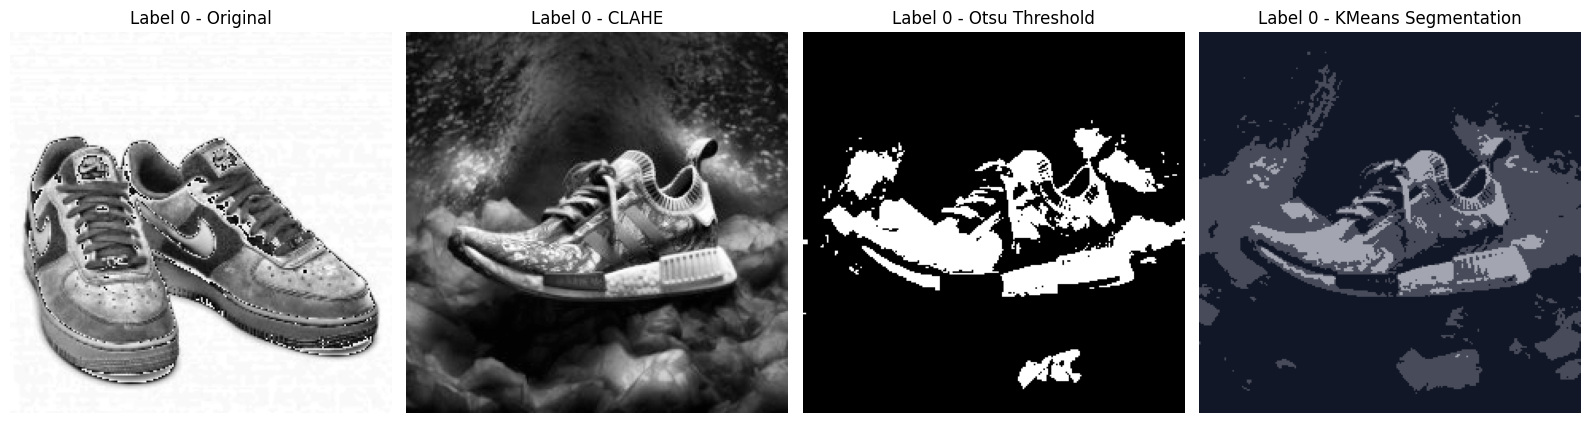

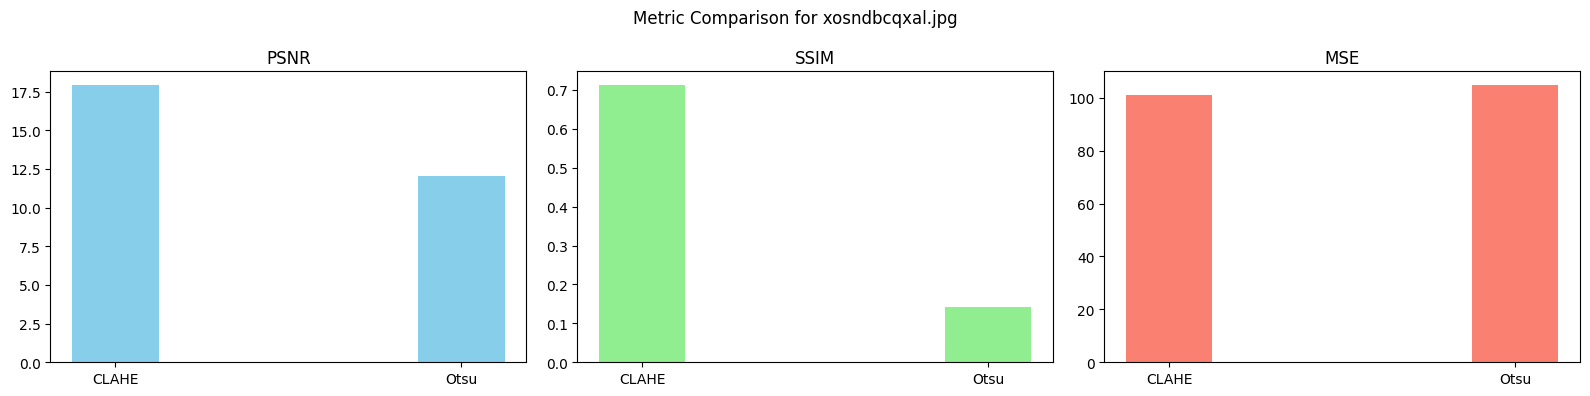

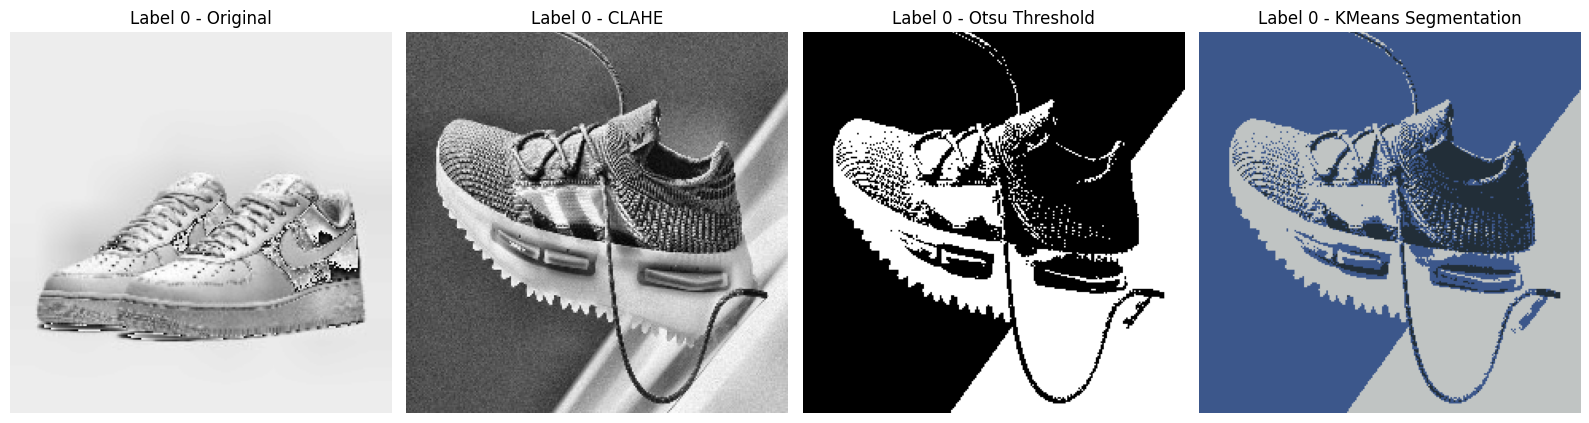

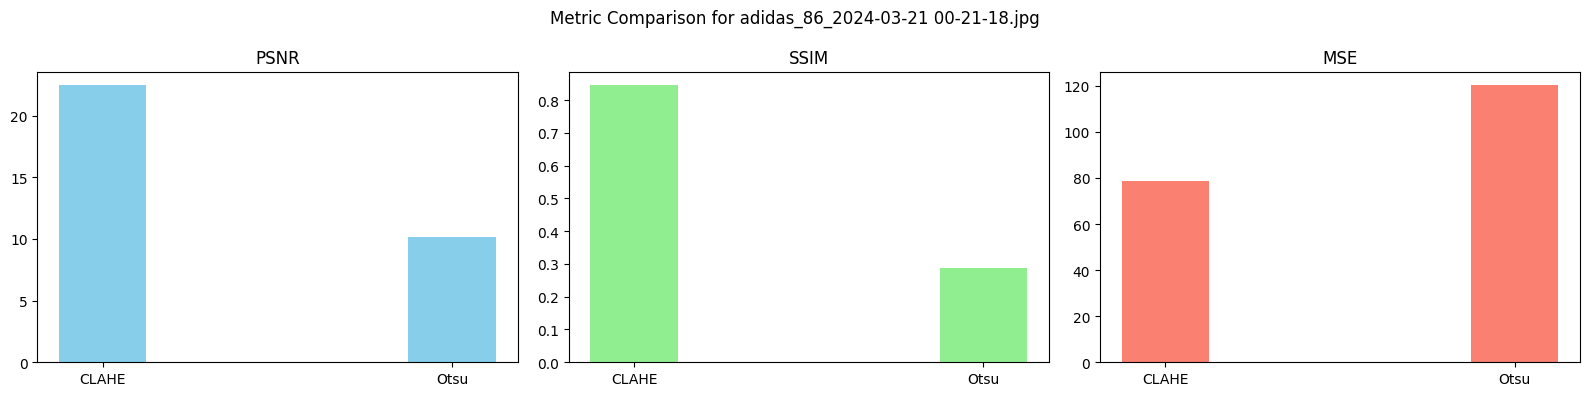

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd

def compute_metrics(original_gray, processed_gray):
    """
    Compute PSNR, SSIM, and MSE between the original grayscale image and a processed image.
    """
    mse_val = np.mean((original_gray - processed_gray) ** 2)
    psnr_val = psnr(original_gray, processed_gray, data_range=original_gray.max() - original_gray.min())
    ssim_val, _ = ssim(original_gray, processed_gray, full=True)
    return psnr_val, ssim_val, mse_val

def preprocess_image_with_metrics(image_path):
    """
    Apply preprocessing steps and compute metrics for each method.
    """
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Error reading image: {image_path}")

    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    otsu = apply_otsu(gray)
    kmeans = apply_kmeans(original_rgb)

    # Compute metrics
    metrics = {
        "Image": [],  # Add this column to store the image name
        "Method": [],
        "PSNR": [],
        "SSIM": [],
        "MSE": [],
    }

    for method, processed_gray in zip(["CLAHE", "Otsu"], [clahe, otsu]):
        psnr_val, ssim_val, mse_val = compute_metrics(gray, processed_gray)
        metrics["Image"].append(os.path.basename(image_path))  # Add image name here
        metrics["Method"].append(method)
        metrics["PSNR"].append(psnr_val)
        metrics["SSIM"].append(ssim_val)
        metrics["MSE"].append(mse_val)

    metrics_df = pd.DataFrame(metrics)
    return clahe, otsu, kmeans, metrics_df


# Example Visualization in Data Loading
for i, (images, labels) in enumerate(train_loader):
    if i == 0:  # Visualize only the first batch
        print(f"Visualizing batch {i + 1}:")
        for idx, (img, label) in enumerate(zip(images, labels)):
            original_path = dataset.images[train_idx[idx]]  # Correct image path indexing
            clahe, otsu, kmeans, metrics_df = preprocess_image_with_metrics(original_path)
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * 255).astype(np.uint8)
            plot_comparisons(img_np, clahe, otsu, kmeans, title_prefix=f"Label {label.item()} - ")

            # Plot real metrics
            plot_metrics_chart(metrics_df, original_path)

        break  # Only visualize the first batch


Epoch 1: 100%|██████████| 872/872 [32:21<00:00,  2.23s/it]


Epoch 1: Loss=264.3790, Accuracy=87.04%


Epoch 2: 100%|██████████| 872/872 [25:10<00:00,  1.73s/it]


Epoch 2: Loss=95.6320, Accuracy=96.79%


Epoch 3: 100%|██████████| 872/872 [14:49<00:00,  1.02s/it]


Epoch 3: Loss=72.6617, Accuracy=97.36%


Epoch 4: 100%|██████████| 872/872 [15:43<00:00,  1.08s/it]


Epoch 4: Loss=51.7556, Accuracy=98.05%


Epoch 5: 100%|██████████| 872/872 [17:50<00:00,  1.23s/it]


Epoch 5: Loss=42.4001, Accuracy=98.62%


Epoch 6: 100%|██████████| 872/872 [17:49<00:00,  1.23s/it]


Epoch 6: Loss=33.1830, Accuracy=98.91%


Epoch 7: 100%|██████████| 872/872 [17:57<00:00,  1.24s/it]


Epoch 7: Loss=26.8962, Accuracy=99.14%


Epoch 8: 100%|██████████| 872/872 [17:56<00:00,  1.23s/it]



Epoch 8: Loss=25.5883, Accuracy=98.91%

✅ F1 Score: 0.9793

✅ F1 Score: 0.9793


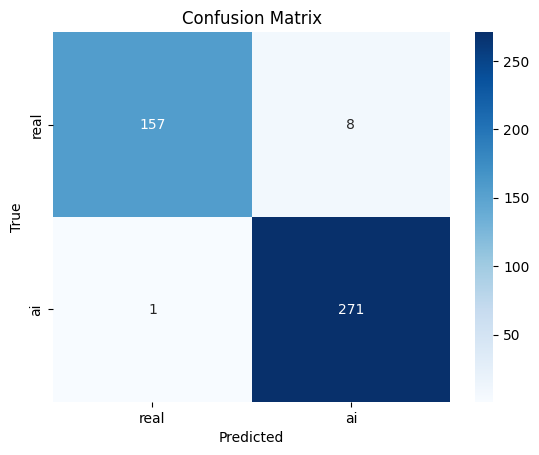

In [100]:
# ---------------------
# Train & Evaluate
# ---------------------
model = ViT_GNN_Classifier(freeze_vit=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)

epochs = 8
for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        vit_features = model.vit(images)
        graph_data = generate_real_graph(vit_features)

        outputs = model(images, graph_data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={100*correct/len(train_loader.dataset):.2f}%")


# ---------------------
# Evaluation with F1 and Confusion Matrix
# ---------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        vit_features = model.vit(images)
        graph_data = generate_real_graph(vit_features)
        outputs = model(images, graph_data)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"\n✅ F1 Score: {f1:.4f}")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "ai"], yticklabels=["real", "ai"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ F1 Score: 0.9793


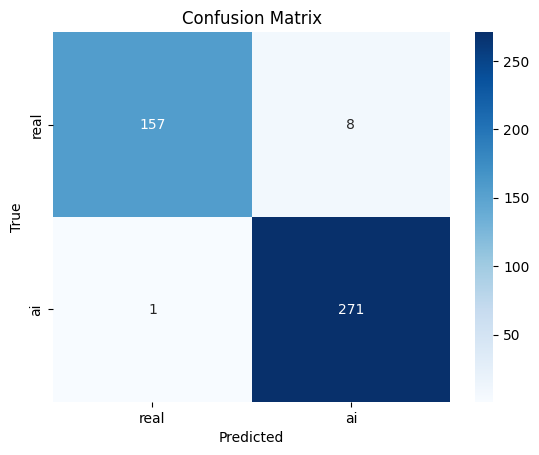

In [102]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and compute metrics.
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test dataset
        device: Device ('cpu' or 'cuda') to run the evaluation
    Returns:
        F1 score and confusion matrix
    """
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Extract features and prepare graph data
            vit_features = model.vit(images)
            graph_data = generate_real_graph(vit_features)

            # Forward pass
            outputs = model(images, graph_data)
            preds = outputs.argmax(dim=1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return f1, cm

# ---------------------
# Run Evaluation
# ---------------------
f1, cm = evaluate_model(model, test_loader, device)

# Print F1 Score
print(f"\n✅ F1 Score: {f1:.4f}")

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "ai"], yticklabels=["real", "ai"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [103]:
# Save the entire model
torch.save(model, "vit_gnn_model_entire.pth")



Accuracy: 0.98
Precision: 0.97
Recall: 1.00
F1 Score: 0.98


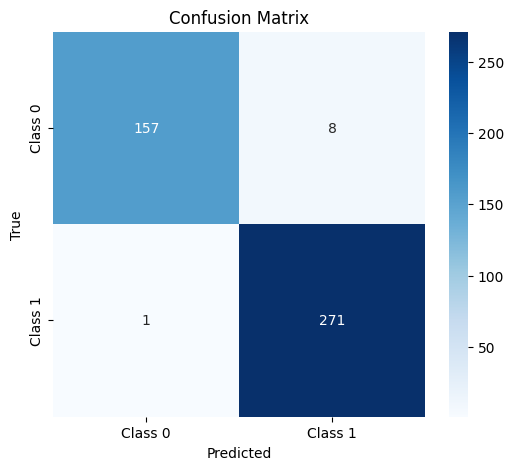


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97       165
     Class 1       0.97      1.00      0.98       272

    accuracy                           0.98       437
   macro avg       0.98      0.97      0.98       437
weighted avg       0.98      0.98      0.98       437



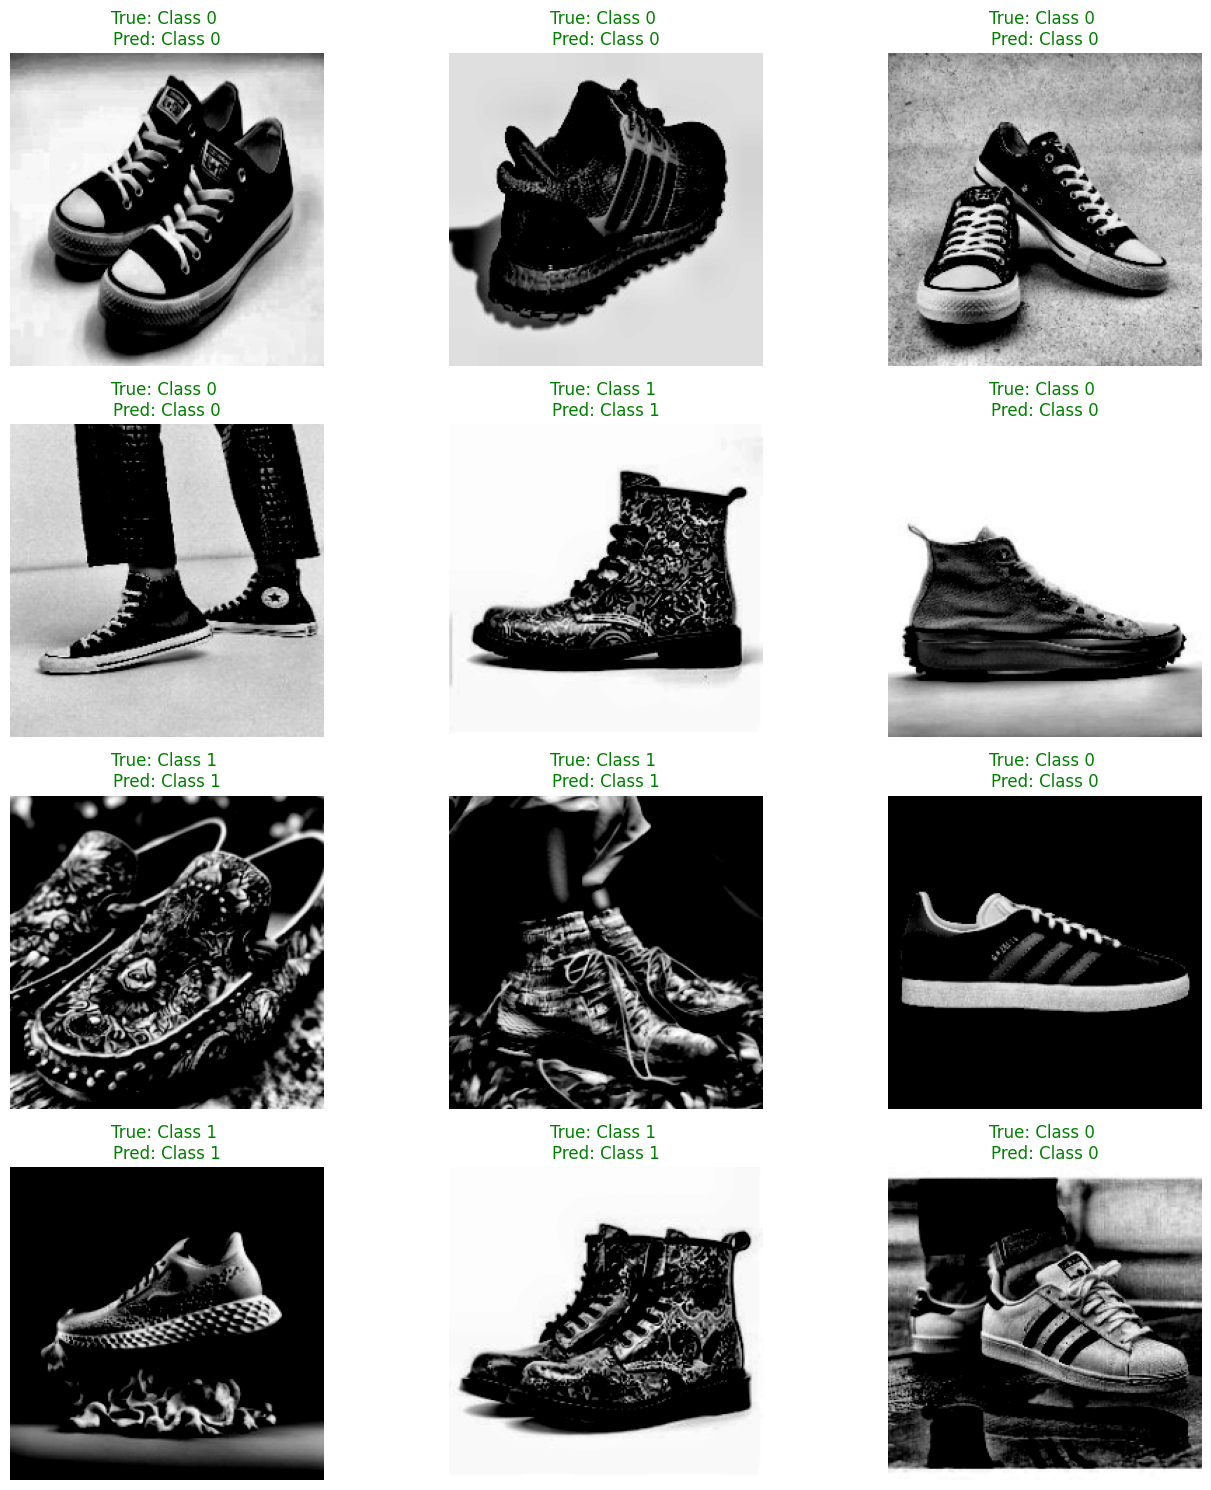

In [107]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# --- ALLOWLIST + LOAD MODEL ---
torch.serialization.add_safe_globals([ViT_GNN_Classifier])

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- EVALUATION ---
all_labels = []
all_predictions = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        if len(images) == 0 or len(labels) == 0:  # Skip empty batches
            print("Skipping empty batch.")
            continue
        
        images, labels = images.to(device), labels.to(device)

        num_nodes = images.shape[0]
        if num_nodes == 0:  # Skip cases with no nodes
            print("Skipping batch with no nodes.")
            continue

        # Construct edge_index and add self-loops
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        # Reshape images and extract features
        images = images.view(-1, 3, 224, 224)
        vit_features = model.vit(images)
        graph_data = Data(x=vit_features, edge_index=edge_index.to(device))

        # Model forward pass
        outputs = model(images, graph_data)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu().numpy())  # Save images for plotting later

# --- METRICS ---
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- CLASSIFICATION REPORT ---
print("\nClassification Report:\n")
print(classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1"]))

# --- RANDOM PREDICTION PLOTTING FUNCTION ---
def plot_prediction(all_images, all_labels, all_predictions, n_images, class_names):
    """
    Plot random test images with their true and predicted labels.

    Args:
        all_images (list or array): The test images.
        all_labels (list): True labels.
        all_predictions (list): Predicted labels.
        n_images (int): Number of images to plot.
        class_names (list): List of class names.
    """
    num_images = len(all_images)
    random_indices = random.sample(range(num_images), n_images)

    plt.figure(figsize=(14, 15))
    for i, idx in enumerate(random_indices):
        img = all_images[idx].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        true_label = all_labels[idx]
        pred_label = all_predictions[idx]

        plt.subplot(4, 3, i+1)
        plt.imshow(np.clip(img, 0, 1))  # Clip values between 0 and 1 for display
        title_color = 'g' if true_label == pred_label else 'r'
        plt.title(f"True: {class_names[true_label]} \nPred: {class_names[pred_label]}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- CALL THE FUNCTION ---
class_names = ["Class 0", "Class 1"]  # Customize your class names here
plot_prediction(all_images, all_labels, all_predictions, n_images=12, class_names=class_names)
